Advanced Modeler Notebook

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    roc_auc_score, 
    classification_report, 
    RocCurveDisplay,
    confusion_matrix
)

In [2]:
# --- 1. LOAD PREPROCESSED DATA ---
print("Loading preprocessed data...")

# Load your saved files
train_df = pd.read_csv("../data/train_processed.csv")
test_df = pd.read_csv("../data/test_processed.csv")

# --- 2. RE-CREATE X AND y ---
# Re-split the data back into features (X) and target (y)
X_train = train_df.drop(columns=["at_risk"])
y_train = train_df["at_risk"]

X_test = test_df.drop(columns=["at_risk"])
y_test = test_df["at_risk"]

print("Data loaded and split successfully!")

Loading preprocessed data...
Data loaded and split successfully!


In [3]:
#  BLOCK TO TEST DEPTHS ---


print("\n" + "="*30)
print("Finding the best max_depth for Random Forest...")
print("="*30)

# The list of depths to test
depths_to_test = [3, 5, 7, 10, 15, None]

# Store results to find the best
best_depth = None
best_f1 = -1 # Start with -1 so any score is better

for depth in depths_to_test:
    
    # 1. Initialize the Classifier (matching your settings)
    model = RandomForestClassifier(
        max_depth=depth, 
        n_estimators=100, 
        random_state=42,
        class_weight='balanced', # Added this from your code
        n_jobs=-1
    )
    
    # 2. Train the model
    model.fit(X_train, y_train)
    
    # 3. Make predictions on the test set
    pred = model.predict(X_test)
    
    # 4. Calculate classification scores
    f1 = f1_score(y_test, pred)
    
    depth_label = "None (Full)" if depth is None else depth
    print(f"Depth = {depth_label}: F1-Score = {f1:.4f}")
    
    # 5. Check if this is the best model so far
    if f1 > best_f1:
        best_f1 = f1
        best_depth = depth

print("\n--- Results ---")
print(f"Best F1-Score: {best_f1:.4f} achieved at max_depth = {best_depth}")
print("="*30 + "\n")


Finding the best max_depth for Random Forest...
Depth = 3: F1-Score = 0.3662
Depth = 5: F1-Score = 0.3636
Depth = 7: F1-Score = 0.3607
Depth = 10: F1-Score = 0.4151
Depth = 15: F1-Score = 0.4211
Depth = None (Full): F1-Score = 0.4211

--- Results ---
Best F1-Score: 0.4211 achieved at max_depth = 15



In [5]:
# 1. BUILD & TUNE ENSEMBLE MODEL (RANDOM FOREST)
print("="*30)
print("Training Random Forest...")
print("="*30)
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=15, 
    random_state=42, 
    class_weight='balanced' 
)
rf_model.fit(X_train, y_train)

Training Random Forest...


,n_estimators,100
,criterion,'gini'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [6]:
# 2. BUILD & TUNE NEURAL NETWORK 
print("\n" + "="*30)
print("Training Neural Network...")
print("="*30)

# Define the Neural Network (MLPClassifier)
nn_model = MLPClassifier(
    hidden_layer_sizes=(32, 16), 
    max_iter=500, 
    random_state=42,
    early_stopping=True # Good for preventing overfitting
)

# Now, train the model
nn_model.fit(X_train, y_train)


Training Neural Network...


,hidden_layer_sizes,"(32, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,500
,shuffle,True
,random_state,42


In [7]:
# 3. DOCUMENT PERFORMANCE (Accuracy, F1, AUC)
print("\n" + "="*30)
print("Model Evaluation")
print("="*30)


Model Evaluation


In [9]:
# Get predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_nn = nn_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
y_proba_nn = nn_model.predict_proba(X_test)[:, 1]

In [10]:
# Store results in a DataFrame for easy reporting
results = {
    "Random Forest": {
        "Accuracy": accuracy_score(y_test, y_pred_rf),
        "F1-Score": f1_score(y_test, y_pred_rf),
        "AUC": roc_auc_score(y_test, y_proba_rf)
    },
    "Neural Network": {
        "Accuracy": accuracy_score(y_test, y_pred_nn),
        "F1-Score": f1_score(y_test, y_pred_nn),
        "AUC": roc_auc_score(y_test, y_proba_nn)
    }
}
results_df = pd.DataFrame(results)
print(results_df)

          Random Forest  Neural Network
Accuracy       0.830769        0.805128
F1-Score       0.421053        0.441176
AUC            0.789091        0.746869


In [8]:
print("\n--- Random Forest Classification Report ---")
print(classification_report(y_test, y_pred_rf, target_names=["Passed", "At-Risk"]))

print("\n--- Neural Network Classification Report ---")
print(classification_report(y_test, y_pred_nn, target_names=["Passed", "At-Risk"]))


--- Random Forest Classification Report ---
              precision    recall  f1-score   support

      Passed       0.89      0.93      0.91       165
     At-Risk       0.48      0.37      0.42        30

    accuracy                           0.84       195
   macro avg       0.68      0.65      0.66       195
weighted avg       0.83      0.84      0.83       195


--- Neural Network Classification Report ---
              precision    recall  f1-score   support

      Passed       0.90      0.86      0.88       165
     At-Risk       0.39      0.50      0.44        30

    accuracy                           0.81       195
   macro avg       0.65      0.68      0.66       195
weighted avg       0.83      0.81      0.81       195




Saved model_roc_curve_comparison.png


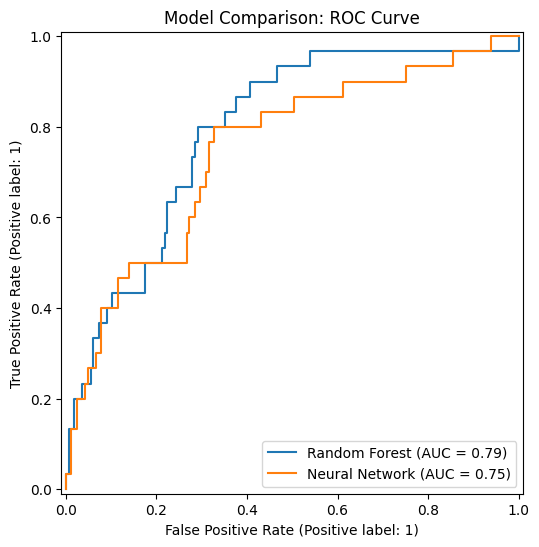

In [9]:
# 4. DELIVERABLES (PLOTS FOR INTERPRETATION)

# --- ROC Curve Comparison (for "color-coded charts") ---
fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_estimator(rf_model, X_test, y_test, name="Random Forest", ax=ax)
RocCurveDisplay.from_estimator(nn_model, X_test, y_test, name="Neural Network", ax=ax)
plt.title("Model Comparison: ROC Curve")
plt.savefig("model_roc_curve_comparison.png")
print("\nSaved model_roc_curve_comparison.png")

In [ ]:
# --- Feature Importance (for the "Interpreter" Role 4) ---
# Get feature importances from RF
importances = rf_model.feature_importances_
feature_names = X_train.columns[selector.get_support()] # Get names from selector

In [ ]:
# Create a DataFrame for easy plotting
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

In [ ]:
plt.figure(figsize=(10, 8))
sns.barplot(x="Importance", y="Feature", data=importance_df.head(15)) # Top 15
plt.title("Random Forest: Top 15 Feature Importances")
plt.tight_layout()
plt.savefig("random_forest_feature_importance.png")
print("Saved random_forest_feature_importance.png")

In [ ]:
# --- Confusion Matrix (also good for presentation) ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=ax1, 
            xticklabels=["Passed", "At-Risk"], yticklabels=["Passed", "At-Risk"])
ax1.set_title("Random Forest Confusion Matrix")
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Actual")

cm_nn = confusion_matrix(y_test, y_pred_nn)
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Oranges', ax=ax2,
            xticklabels=["Passed", "At-Risk"], yticklabels=["Passed", "At-Risk"])
ax2.set_title("Neural Network Confusion Matrix")
ax2.set_xlabel("Predicted")
ax2.set_ylabel("Actual")

plt.tight_layout()
plt.savefig("model_confusion_matrices.png")
print("Saved model_confusion_matrices.png")

In [ ]:
# 1. GET IMPORTANCES FROM YOUR TRAINED MODEL
importances = rf_model.feature_importances_

# 2. GET THE FEATURE NAMES
# These are simply the columns from your X_train DataFrame
feature_names = X_train.columns

# 3. CREATE A DATAFRAME TO HOLD THE RESULTS
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False) # Sort by most important

# 4. PLOT THE RESULTS
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15), palette='viridis')
plt.title('Top 15 Most Important Features (According to Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

